## ASTR777 Star and Planet Formation Problem Set 6
### Image Analysis - the spirals of IM Lup

# STARTER NOTEBOOK

In [5]:
import os, sys, time           
import numpy as np             
from astropy.io import fits
from astropy import wcs
from astropy.nddata.utils import Cutout2D
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)
from scipy.interpolate import interp1d, interp2d
from matplotlib.gridspec import GridSpec

%matplotlib inline

In [6]:
# set up plot parameters
import matplotlib as mpl
mpl.rc('xtick.major', size=5, pad=3, width=2)
mpl.rc('ytick.major', size=5, pad=3, width=2)
mpl.rc('xtick.minor', size=2, pad=3, width=2)
mpl.rc('ytick.minor', size=2, pad=3, width=2)
mpl.rc('axes', linewidth=2, labelsize=14, titlesize=18)
mpl.rc('legend', fontsize=14)
mpl.rc('lines', markersize=5)
mpl.rc('font', size=12)
cmap = 'magma'

In [7]:
# disk target name
disk_name = 'IMLup'

# geometric properties (from Huang et al. 2018 DSHARP II)
offRA, offDEC = -0.001, +0.001
incl, PA = 47.5, 144.5
inclr, PAr = np.radians(incl), np.radians(PA)
rout = 1.2

In [8]:
# load the .FITS file contents
hdu = fits.open('IMLup_continuum.fits')
data = 1e3 * np.squeeze(hdu[0].data)
header = hdu[0].header
w = wcs.WCS(header)
w_ra_dec = w.sub(2)
# verify that the size is 4000x4000 with step size 0.03 arcsec
print(data.shape)

# cutout the central quarter region, 1.5 x 1.5 arcsec (1000 pixels)
cutout = Cutout2D(data, (2000, 2000), (1000, 1000), wcs=w_ra_dec)
image = cutout.data
print(image.shape)

(4000, 4000)
(1000, 1000)


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [9]:
subhd = cutout.wcs.to_header()
ny, nx = image.shape
RAo = 3600 * subhd['CDELT1'] * (np.arange(nx) - (subhd['CRPIX1'] - 1))
DECo = 3600 * subhd['CDELT2'] * (np.arange(ny) - (subhd['CRPIX2'] - 1))
RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC

freq = header['CRVAL3']
beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']
beam_area = (np.pi * beam_maj * beam_min / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

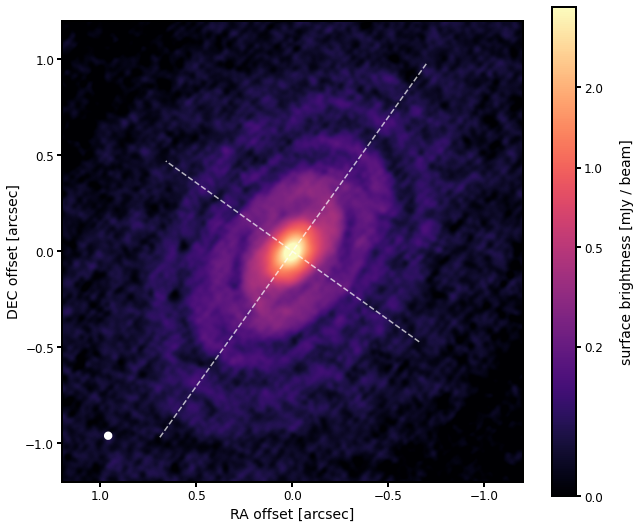

In [10]:
# image setups
im_bounds = (RAo_shift.max(), RAo_shift.min(), DECo_shift.min(), DECo_shift.max())
dRA_lims, dDEC_lims = [rout, -rout], [-rout, rout]

# intensity limits, and stretch
vmin, vmax = 0.0, 4.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(0.03))
#norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch(10))

# image plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')

# minor and major axes
rmaj = np.linspace(-rout, rout, 2)
ax.plot(rmaj * np.sin(PAr), rmaj * np.cos(PAr), '--w', alpha=0.7)
ax.plot(rmaj * np.cos(inclr) * np.sin(PAr - 0.5*np.pi), 
        rmaj * np.cos(inclr) * np.cos(PAr - 0.5*np.pi), '--w', alpha=0.7)

# limits, labeling
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=90, labelpad=17)

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

## Now referring to the problem set, derotate and deproject the image

# THIS PART IS DUE BY NOVEMBER 15TH IN TIME TO COLLECTIVELY HACK THE NEXT STEPS